# Random forest + temporal smoothing 

In this section, we will train a random forest on the extracted windows
from the previous section. We will explore ways to account for the temporal
dependency such as mode smoothing and hidden Markov model.

## Setup

In [1]:
import os
import time
import re
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm
import utils  # helper functions -- check out utils.py

# For reproducibility
np.random.seed(42)


## Load dataset 

In [2]:

# Path to your extracted windows
DATASET_PATH = 'dataset/'
print(f'Content of {DATASET_PATH}')
print(os.listdir(DATASET_PATH))

with open(DATASET_PATH+'info.json', 'r') as f:
    info = json.load(f)  # load metadata

X = np.memmap(DATASET_PATH+'X.dat', mode='r', dtype=info['X_dtype'], shape=tuple(info['X_shape']))
Y = np.memmap(DATASET_PATH+'Y.dat', mode='r', dtype=info['Y_dtype'], shape=tuple(info['Y_shape']))
T = np.memmap(DATASET_PATH+'T.dat', mode='r', dtype=info['T_dtype'], shape=tuple(info['T_shape']))
P = np.memmap(DATASET_PATH+'P.dat', mode='r', dtype=info['P_dtype'], shape=tuple(info['P_shape']))

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('T shape:', T.shape)
print('P shape:', P.shape)



Content of dataset/
['Y.dat', 'info.json', 'P.dat', 'T.dat', 'X.dat']
X shape: (294309, 3000, 3)
Y shape: (294309,)
T shape: (294309,)
P shape: (294309,)


## Feature extraction
The feature extraction code used in the previous section can also be found in
*utils.py* file. Feel free to engineer your own features!

*Note: this may take a while*

In [3]:

# # Extract features
# X_feats = pd.DataFrame([utils.extract_features(x) for x in X])

# # (Optional) Save to disk to avoid recomputation in future runs
# X_feats.to_pickle('X_feats.pkl')

# Reload features
X_feats = pd.read_pickle('X_feats.pkl')

print(X_feats)


           xMean     yMean     zMean      xStd      yStd      zStd    xRange  \
0      -0.327887  0.054434  0.951081  0.005676  0.000967  0.004923  0.015485   
1      -0.327989  0.054399  0.951277  0.005636  0.000950  0.005042  0.015485   
2      -0.328359  0.054326  0.951267  0.005487  0.000900  0.004972  0.015485   
3      -0.327946  0.054315  0.951216  0.005720  0.000949  0.004803  0.021637   
4      -0.328102  0.054285  0.950906  0.005594  0.000485  0.004558  0.015485   
...          ...       ...       ...       ...       ...       ...       ...   
294304 -0.447416  0.086162  0.891438  0.006127  0.001979  0.001852  0.015990   
294305 -0.447271  0.086255  0.891351  0.006057  0.002229  0.001403  0.015630   
294306 -0.380982  0.109936  0.919054  0.049273  0.013007  0.018793  0.265705   
294307 -0.378788  0.115906  0.921385  0.003234  0.003575  0.003833  0.015630   
294308 -0.379159  0.115951  0.921023  0.002498  0.003494  0.004281  0.021882   

          yRange    zRange      xIQR  .

Note the great dimensionality reduction, from $3000 \times 3$ to just $22$
values per window &mdash; a reduction of about 400 times.

## Train/test split

In [4]:

# Take out 10 participants
test_ids = ['002', '003', '004', '005', '006', 
            '007', '008', '009', '010', '011']
mask_test = np.isin(P, test_ids)
mask_train = ~mask_test
X_train, Y_train, P_train, T_train = \
    X_feats[mask_train], Y[mask_train], P[mask_train], T[mask_train]
X_test, Y_test, P_test, T_test = \
    X_feats[mask_test], Y[mask_test], P[mask_test], T[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (274462, 22)
Shape of X_test: (19847, 22)


## Train a random forest classifier

*Note: this may take a while*

In [5]:
# Argument oob_score=True to be used for HMM smoothing (see below)
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   52.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.2min finished


BalancedRandomForestClassifier(n_estimators=2000, n_jobs=4, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not minority', verbose=1)

## Model performance

In [6]:

Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('In sample:\n', metrics.classification_report(Y_train, Y_train_pred))
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred)) 


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 2000 

Overall, the model seems to do well in distinguishing between very inactive
periods ("sit-stand" and "sleep") and very active ones ("bicycling"), but there
seems to be confusion between the remaining activities.

## Plot predicted vs. true activity profiles

Using our utility function, let's plot the activity profile for participant
`006`. Here we also pass the acceleration mean for plotting purposes.

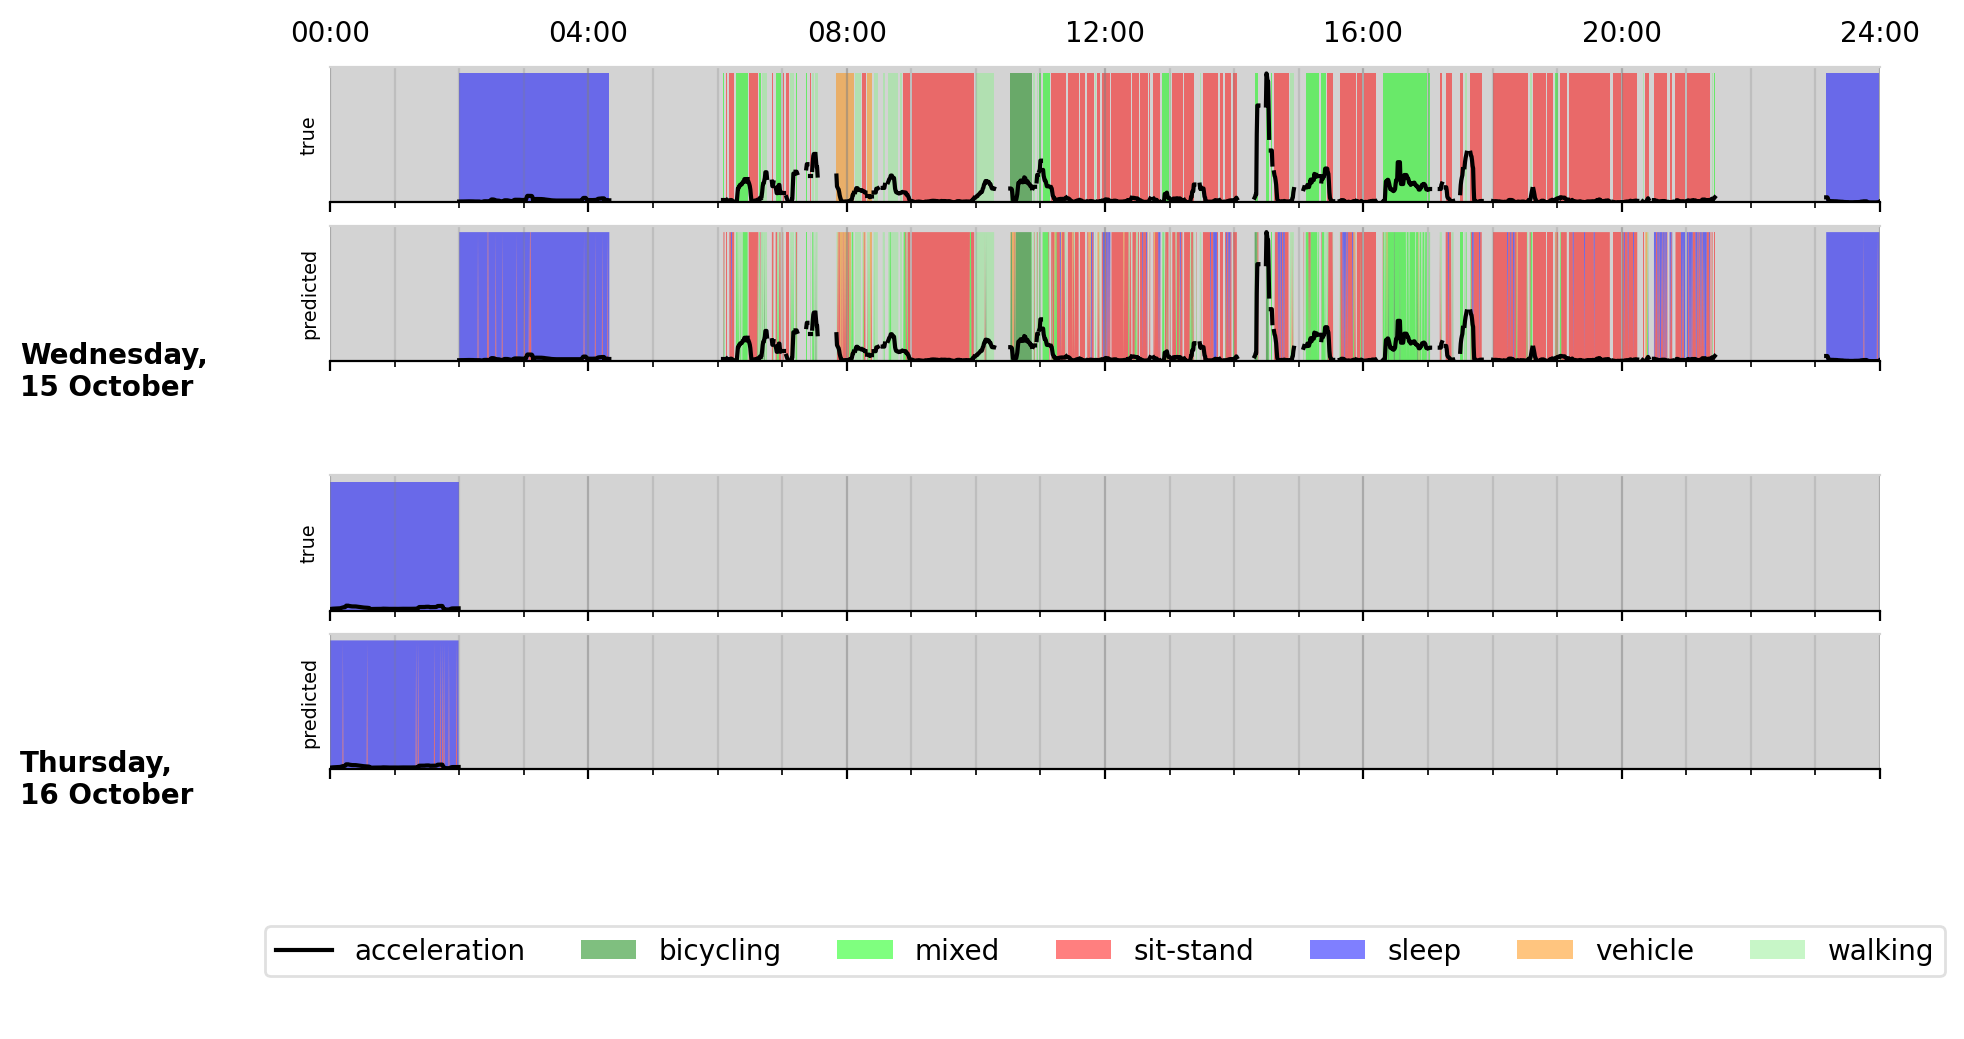

In [7]:
mask = P_test=='006'
utils.plot_compare_activity(T_test[mask], 
                      Y_test[mask],
                      Y_test_pred[mask], 
                      X_test.loc[mask, 'mean'])



The predictions look good at first glance (after all, the majority of
activities happen to be of the inactive type for which the model performs
well &mdash; this is what the high `weighted avg` in the performance
report reflects). But we find some awkward sequence of activities in the predictions,
for example broken "sleep" patterns insterspersed with "sit-stand"
activities. This is because the model does not account for the temporal
dependency and treats the instances as independent from each other.

## Accounting for temporal dependency

### Rolling mode smoothing
Let's use rolling mode smoothing to smooth the model predictions: Pick the
most popular label within a rolling time window.


In [8]:

def mode(alist):
    ''' Mode of a list, but return middle element if ambiguous '''
    m, c = stats.mode(alist)
    m, c = m.item(), c.item()
    if c==1:
        return alist[len(alist)//2]
    return m

def rolling_mode(t, y, window_size='100S'):
    y_dtype_orig = y.dtype
    # Hack to make it work with pandas.Series.rolling()
    y = pd.Series(y, index=t, dtype='category')
    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode, raw=True).astype('int')
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype)
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_orig)
    return y_smooth



Classifier performance -- mode smoothing
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.69      0.90      0.78       347
       mixed       0.55      0.44      0.48      1955
   sit-stand       0.89      0.85      0.87      8523
       sleep       0.96      0.93      0.95      7500
     vehicle       0.39      0.54      0.45       609
     walking       0.32      0.57      0.41       913

    accuracy                           0.82     19847
   macro avg       0.63      0.70      0.66     19847
weighted avg       0.84      0.82      0.83     19847



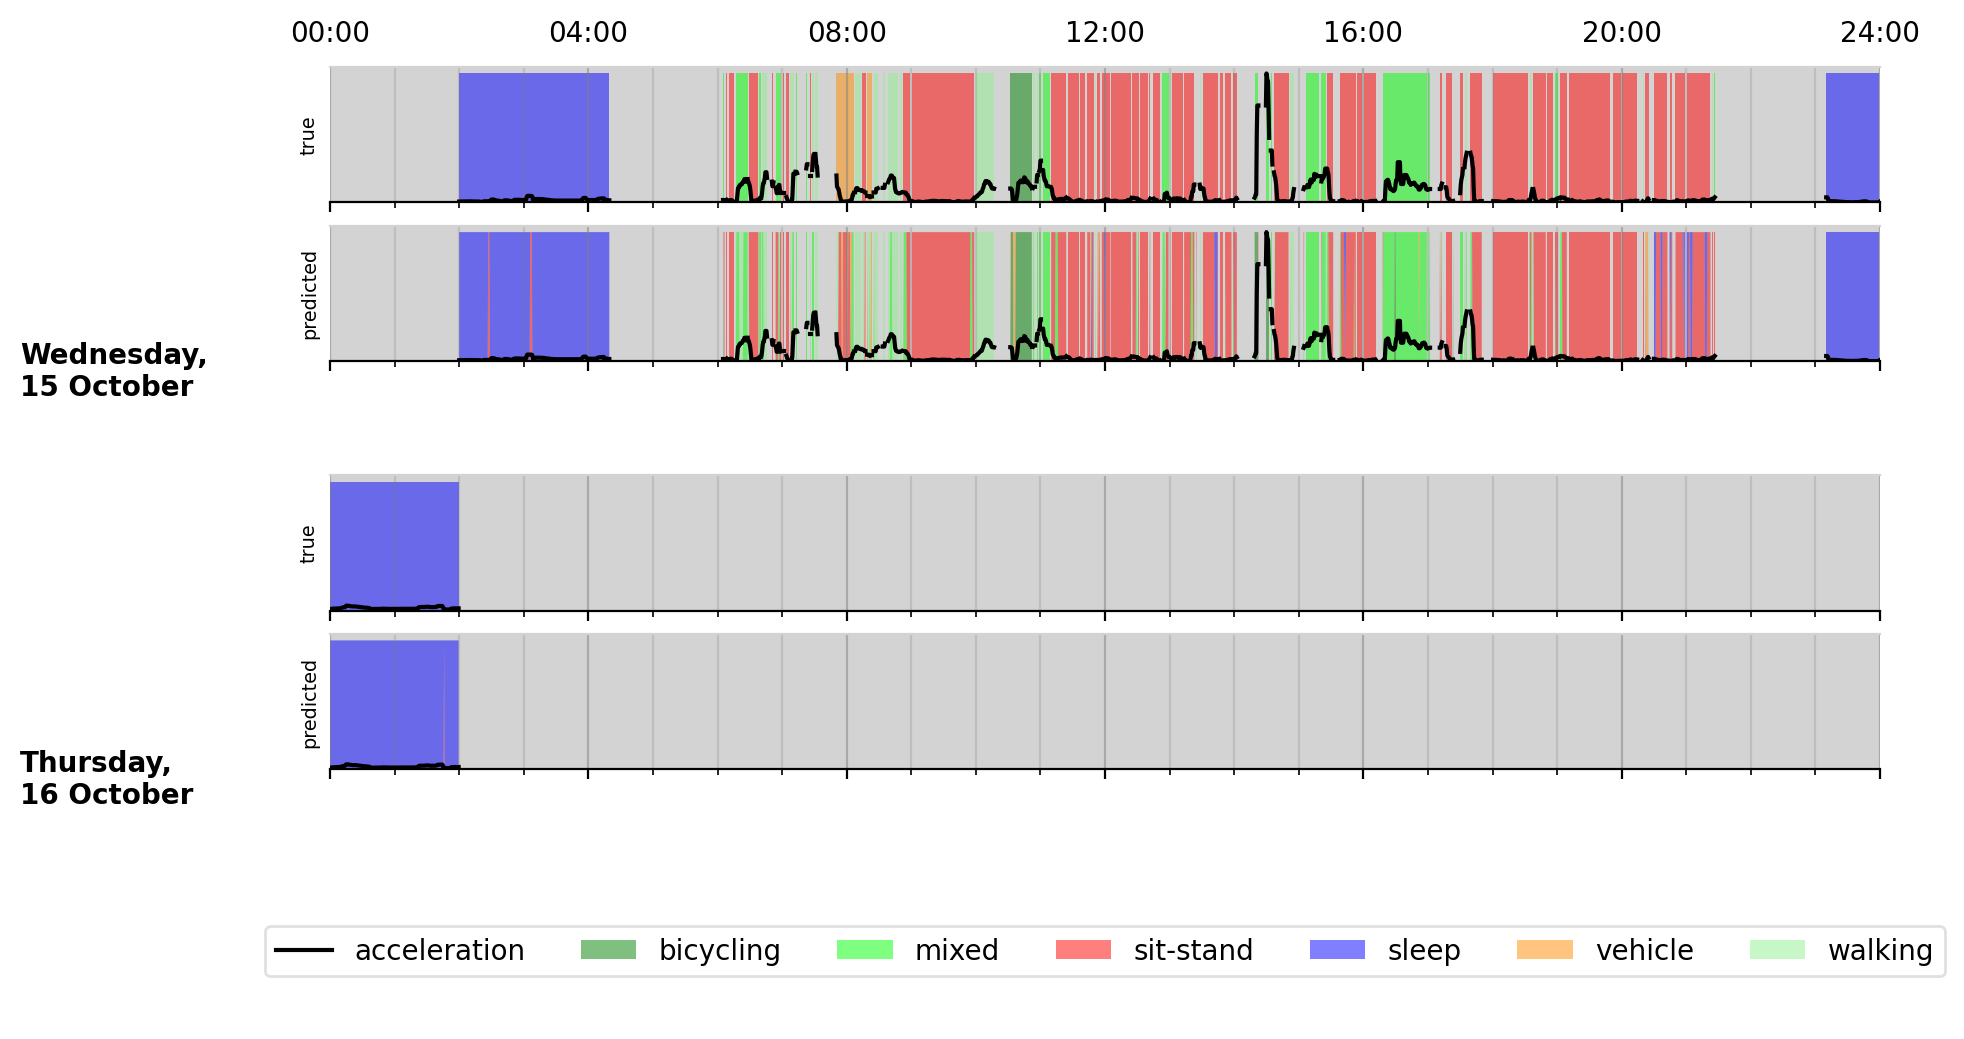

In [9]:

# Smooth the predictions of each participant
Y_test_pred_smooth = []
unqP, indP = np.unique(P_test, return_index=True)
unqP = unqP[np.argsort(indP)]  # keep the order or else we'll scramble our arrays
for p in unqP:
    mask = P_test==p
    Y_test_pred_smooth.append(rolling_mode(T_test[mask], Y_test_pred[mask]))
Y_test_pred_smooth = np.concatenate(Y_test_pred_smooth)

print('\nClassifier performance -- mode smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_smooth)) 

# Check again participant `006`
mask = P_test=='006'
utils.plot_compare_activity(T_test[mask], 
                      Y_test[mask],
                      Y_test_pred_smooth[mask], 
                      X_test.loc[mask, 'mean'])


### Hidden Markov Model

A more principled approch is to use a Hidden Markov Model (HMM). 
Here the random forest predictions are "observations" of the "hidden ground
truth". The emission matrix can be obtained from probabilistic predictions of
the classifier (`predict_proba()`), and the transition matrix can be obtained
from the ground truth sequence of labels. The prior probabilities of the
labels can be user-specified or set as the label rates observed in the
dataset.


In [10]:

def train_hmm(Y_prob, Y_true, labels, uninformative_prior=True):
    ''' https://en.wikipedia.org/wiki/Hidden_Markov_model '''

    nlabels = len(labels)

    if uninformative_prior:  
        # All labels with equal probability
        prior = np.ones(len(labels)) / len(labels)
    else:
        # Label probability equals observed rate
        prior = np.mean(Y_true.reshape(-1,1)==labels, axis=0)

    emission = np.vstack(
        [np.mean(Y_prob[Y_true==label], axis=0) for label in labels]
    )
    transition = np.vstack(
        [np.mean(Y_true[1:][(Y_true==label)[:-1]].reshape(-1,1)==labels, axis=0)
            for label in labels]
    )

    params = {'prior':prior, 'emission':emission, 'transition':transition, 'labels':labels}

    return params


def viterbi(Y_obs, hmm_params):
    ''' https://en.wikipedia.org/wiki/Viterbi_algorithm '''

    def log(x):
        SMALL_NUMBER = 1e-16
        return np.log(x + SMALL_NUMBER)

    prior = hmm_params['prior']
    emission = hmm_params['emission']
    transition = hmm_params['transition']
    labels = hmm_params['labels']

    nobs = len(Y_obs)
    nlabels = len(labels)

    Y_obs = np.where(Y_obs.reshape(-1,1)==labels)[1]  # to numeric

    probs = np.zeros((nobs, nlabels))
    probs[0,:] = log(prior) + log(emission[:, Y_obs[0]])
    for j in range(1, nobs):
        for i in range(nlabels):
            probs[j,i] = np.max(
                log(emission[i, Y_obs[j]]) + \
                log(transition[:, i]) + \
                probs[j-1,:])  # probs already in log scale
    viterbi_path = np.zeros_like(Y_obs)
    viterbi_path[-1] = np.argmax(probs[-1,:])
    for j in reversed(range(nobs-1)):
        viterbi_path[j] = np.argmax(
            log(transition[:, viterbi_path[j+1]]) + \
            probs[j,:])  # probs already in log scale

    viterbi_path = labels[viterbi_path]  # to labels

    return viterbi_path



Classifier performance -- HMM smoothing
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.88      0.90      0.89       347
       mixed       0.70      0.51      0.59      1955
   sit-stand       0.94      0.92      0.93      8523
       sleep       0.98      0.99      0.98      7500
     vehicle       0.63      0.56      0.59       609
     walking       0.33      0.57      0.42       913

    accuracy                           0.88     19847
   macro avg       0.74      0.74      0.73     19847
weighted avg       0.89      0.88      0.88     19847



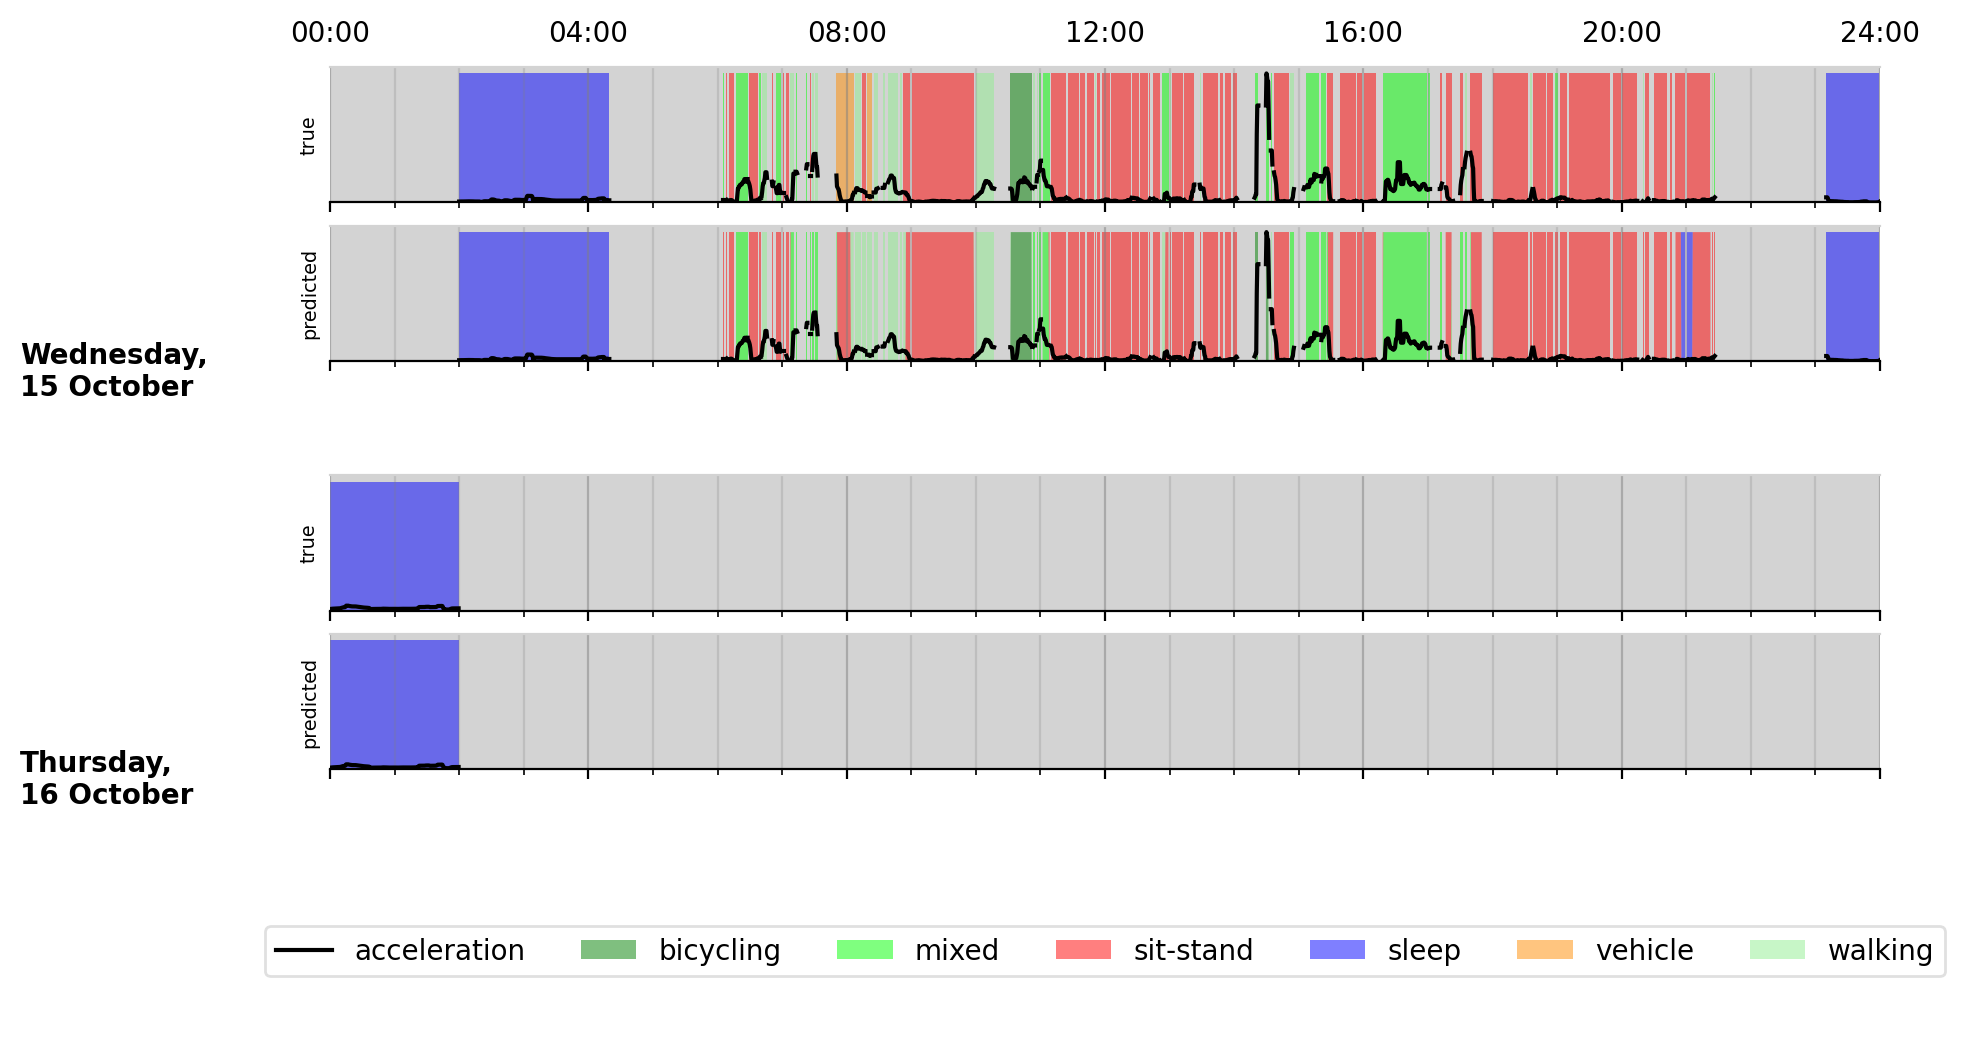

In [11]:

# Use the convenientely provided out-of-bag probability predictions from the
# random forest training. Question: Why is it preferable over 
# Y_train_prob = clf.predict_proba(X_train)?
Y_train_prob = clf.oob_decision_function_  # out-of-bag probability predictions
labels = clf.classes_
hmm_params = train_hmm(Y_train_prob, Y_train, labels)  # obtain HMM matrices/params
Y_test_pred_hmm = viterbi(Y_test_pred, hmm_params)  # smoothing
print('\nClassifier performance -- HMM smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_hmm)) 

# Check again participant `006`
mask = P_test=='006'
utils.plot_compare_activity(T_test[mask], 
                      Y_test[mask],
                      Y_test_pred_hmm[mask], 
                      X_test.loc[mask, 'mean'])


HMM further improves the performance overall.

## Is a simple logistic regression enough?

*Note: this may take a while*

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished

Classifier performance -- Logistic regression
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.98      0.65      0.78       347
       mixed       0.53      0.68      0.60      1955
   sit-stand       0.89      0.90      0.89      8523
       sleep       0.93      0.99      0.96      7500
     vehicle       0.25      0.11      0.15       609
     walking       0.48      0.14      0.22       913

    accuracy                           0.85     19847
   macro avg       0.68      0.58      0.60     19847
weighted avg       0.83      0.85      0.83     19847



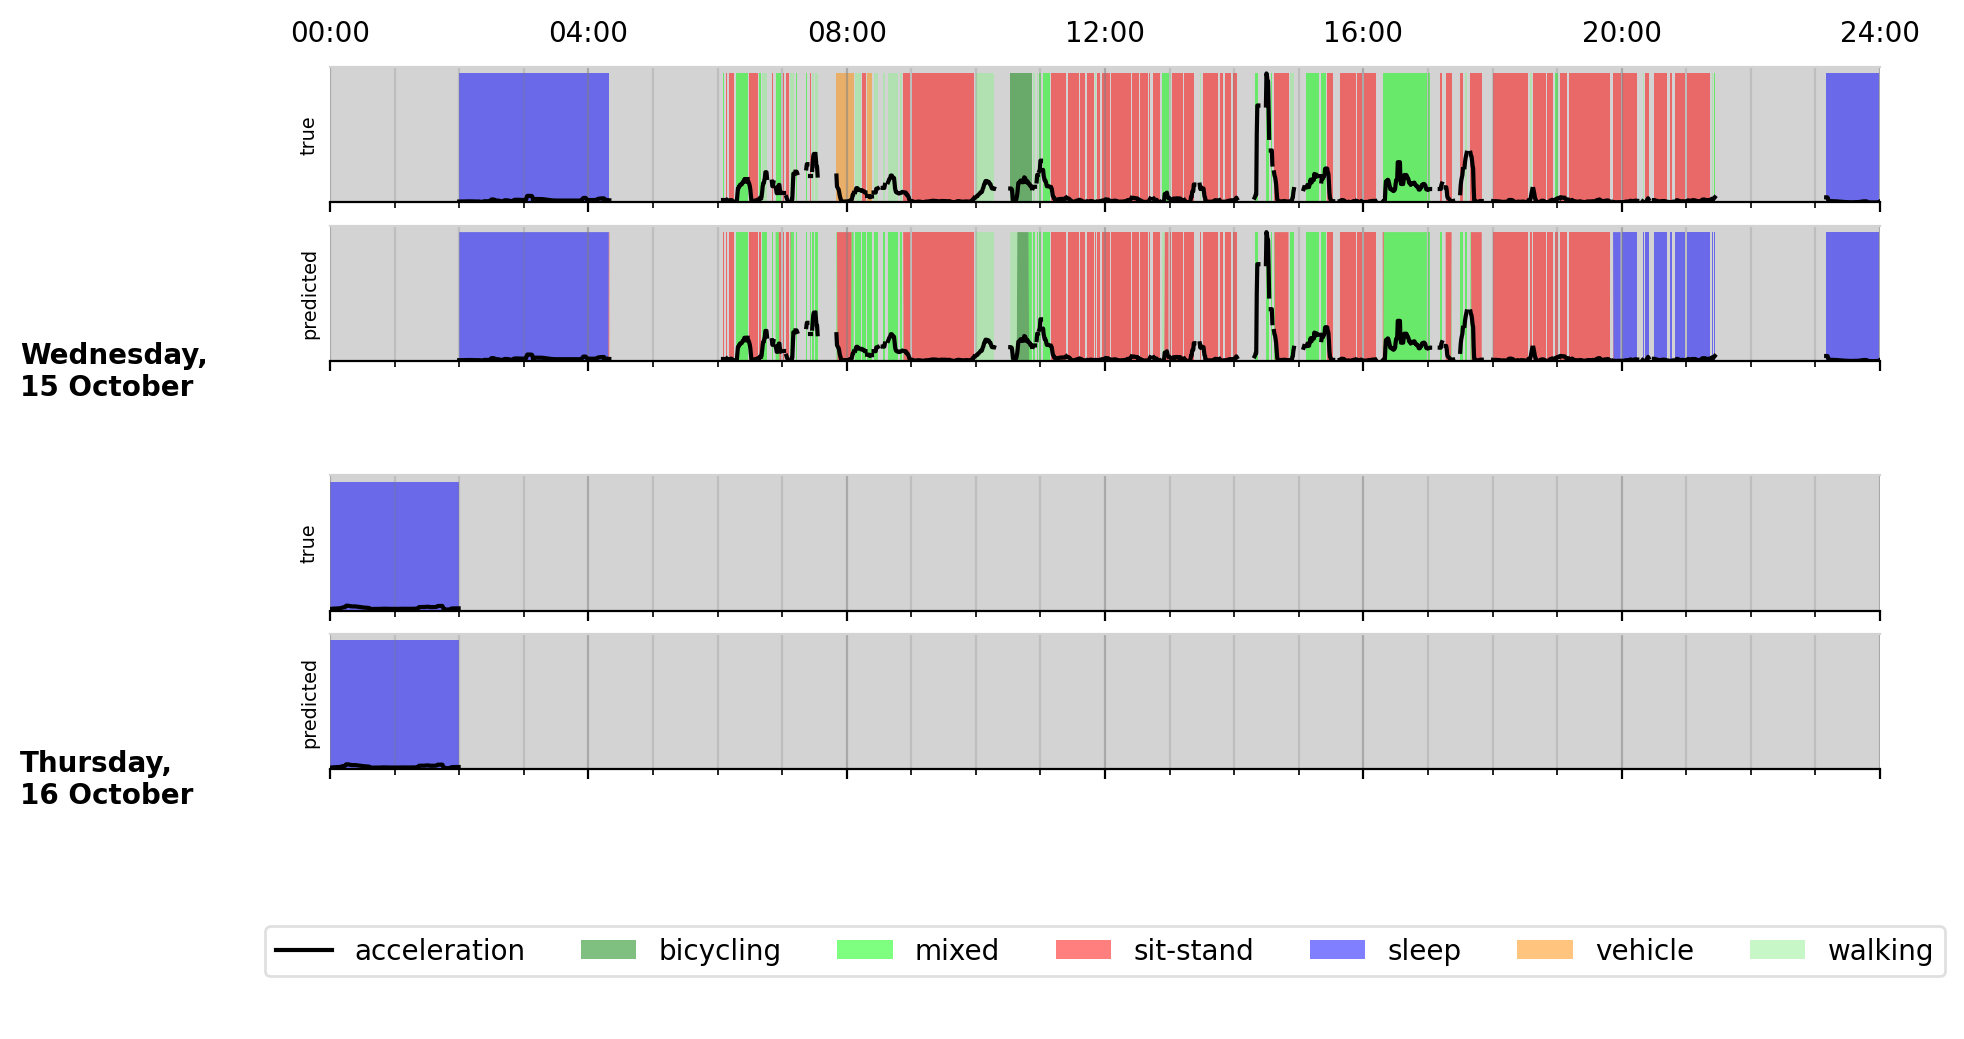

In [13]:
clf_LR = LogisticRegression(
    max_iter=1000, 
    multi_class='multinomial', 
    random_state=42, 
    verbose=1)
scaler = StandardScaler()
pipe = make_pipeline(scaler, clf_LR)
pipe.fit(X_train, Y_train)

Y_test_pred_LR = pipe.predict(X_test)

# HMM smoothing
Y_train_LR_prob = pipe.predict_proba(X_train)  # sorry! LR doesn't provide OOB estimates for free
labels = pipe.classes_
hmm_params_LR = train_hmm(Y_train_LR_prob, Y_train, labels)
Y_test_pred_LR_hmm = viterbi(Y_test_pred_LR, hmm_params_LR)  # smoothing

print('\nClassifier performance -- Logistic regression')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_LR_hmm)) 

# Check again participant `006`
mask = P_test=='006'
utils.plot_compare_activity(T_test[mask], 
                      Y_test[mask],
                      Y_test_pred_LR_hmm[mask], 
                      X_test.loc[mask, 'mean'])
